# Classification Predict

## Table of Contents


1. [Introduction](#1.-Introduction)
    - Problem statement
    - Objective
    
2. [Importing Packages](#2.-Importing-Packages)

3. [Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
    - Load Data 
    
4. [Pre-processing](#4.-Pre-processing)
    - [Removing the Noise](#Removing-the-Noise)
       - [Lowercasing Data](#Lowercasing-Data) 
       - [Removing Contractions](#Removing-Contractions)
       - [Removing Web Urls](#Removing-Web-Urls)
       - [Removing Punctuations](#Removing-Punctuations)
       - [Removing Numbers](#Removing-Numbers)
       - [Removing Extra Space](#Removing-Extra-Space) 
       - [Tokenization](#Tokenization)
       - [Removing Stop Words](#Removing-Stop-Words)
       - [Removing Emojis](#Removing-Emojis)
       - [Removing Punctuation once more](#Removing-Punctuation-once-more)
       - [Tokenization_2](#Tokenization_2)
       - [Stemmer](#Stemmer)
       - [Lemmatization](#Lemmatization)
      
       
    
5. [Feature Engineering](#5.-Feature-Engineering)
    - Bag of Words
    - N-grams
        
6. [Modelling](#6.-Modelling)
7. [Conclusion](#7.-Conclusion)

## 1. Introduction
[Back to Table of Contents](#Table-of-Contents)

###  Problem Statement

Many companies would like to determine how their customers perceive climate change and whether or not they believe it is a real threat. 
Knowledge of this would add to their market research efforts in gauging how their product/service may be received.

An accurate and robust solution to this problem would give the companies access to a broad understanding of consumer sentiment, spanning multiple demographic and geographics, as a result increasing companies' insights and informing future
marketing strategies for the betterment of consumer experience and company performance.



### Objective

Building a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data. The tweets belonging to any of the following class descriptions:

2 News: the tweet links to factual news about climate change

1 Pro: the tweet supports the belief of man-made climate change

0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

-1 Anti: the tweet does not believe in man-made climate change Variable definitions

## 2. Importing Packages
[Back to Table of Contents](#Table-of-Contents)

In [15]:
import nltk
import string
import re
import string
import contractions
import sys  
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from cleantext import clean

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
# from pandas.core.common import SettingWithCopyWarning
from comet_ml import Experiment

In [ ]:
# Only run this cell if you need to install it
pip install comet_ml
pip install cleantext

### Starting comet experiment

In [ ]:
experiment = Experiment(api_key="DgOUdi281ImcebtckQoquGSnl",project_name="general",workspace="bronwyn",)

## 3. Exploratory Data Analysis
[Back to Table of Contents](#Table-of-Contents)

### Load data

In [ ]:
# Display data
data = pd.read_csv("train.csv")
data.head(3)

In [ ]:
#see the min, max and mode(from dictionary) category of the sentiments
data_sorted = data[["message", "sentiment"]]

dict_ = {}

for i in data_sorted["sentiment"]:
    if i in dict_:
        dict_[i] += 1
    else:
        dict_[i] = 1

print("total number of sentiments:", len(data_sorted))
print("counts of the respective sentiments:", dict_)

In [ ]:
#the skewness and kurtosis(lack of ourtliers) of the sentiments
print("skewness: ", data_sorted["sentiment"].skew())
print("kurtosis: ",data_sorted["sentiment"].kurtosis())

In [ ]:
#the frequency distribution of the sentiments
#Thibello
sns.countplot(x = 'sentiment', data = data_sorted, palette="hls")
plt.title("Distribution of Sentiments")

In [ ]:
#counting the number of respective impurities

punctuations = 0
numbers = 0

for i in data_sorted["message"]:
    for k in i.split():
        if k in string.punctuation:
            punctuations+=1
        if k.isdigit():
            numbers += 1
print("punctuations present in the tweets:", punctuations)
print("numbers present in the tweets:", numbers)


## 4. Pre-processing
[Back to Table of Contents](#Table-of-Contents)

### Revise data 

In [ ]:
#making the tweetid the index
data = pd.read_csv("train.csv", index_col = "tweetid")
data.head(3)


In [ ]:
#rearrange the columns for clarity
data_sorted = data[["message", "sentiment"]]
data_sorted.head(3)

## Removing the Noise

### Lowercasing Data

In [ ]:
#make everything lower case
'''
Converting every letter into lowercase helps to understand better what the words 
state.
'''
data_sorted['message'] = data_sorted['message'].str.lower()
data_sorted.head(20)

In [ ]:
data_sorted.tail(20)

### Removing Contractions

In [ ]:
#expand all existing contractions

def expand_contractions(tweet):
    return " ".join([contractions.fix(c) for c in tweet.split()])

data_sorted["message"] = data_sorted["message"].apply(expand_contractions)
data_sorted.head()

### Removing Web Urls

In [ ]:
#remove web urls 
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
data_sorted['message'] = data_sorted['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)
data_sorted.iloc[0]['message']

### Removing Punctuations

Removing punctuation marks assists us to treat every word equally, 
E.g sweet! and sweet are the same without punctuation. 

In [ ]:
#remove all punctuations

def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

data_sorted['message'] = data_sorted['message'].apply(remove_punctuation)
data_sorted.head()

In [ ]:
data_sorted.iloc[0]['message']

### Removing Numbers

"For example, when we are doing sentiment analysis then the number doesn’t hold any specific meaning to the data but if the task is to perform NER (Name Entity Recognition) or POS (Part of Speech tagging) then use the removing of number technique carefully."

In [ ]:
def remove_digits(post):
    return ''.join([i for i in post if not i.isdigit()])

data_sorted['message'] = data_sorted['message'].apply(remove_digits)
data_sorted.head()

In [ ]:
data_sorted.iloc[3]['message']

In [ ]:
len(data_sorted.iloc[3]['message'])

### Removing Extra Space

Removing expace could help reduce the memory usage 

In [ ]:
def remove_extra_space(text):
    return " ".join(text.split())

data_sorted['message'] = data_sorted['message'].apply(remove_extra_space)
data_sorted.head()

In [ ]:
data_sorted.iloc[3]['message']

In [ ]:
len(data_sorted.iloc[3]['message']) 

The decrease in the number of characters shows that extra space have been removed.

### Tokenization

In [ ]:
#tokenisation to treat each word with respect
tokeniser = TreebankWordTokenizer()
data_sorted['message'] = data_sorted['message'].apply(tokeniser.tokenize)

data_sorted

In [ ]:
data_sorted.iloc[0]['message']

### Removing Stop Words

In [ ]:
#remove standard stop words, which are words of insignificance
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]

data_sorted['message'] = data_sorted['message'].apply(remove_stop_words)
data_sorted

In [ ]:
for i in data_sorted["message"]:
    print(i)

### Removing Emojis

In [ ]:
from cleantext import clean

In [ ]:
def remove_emoji(data): 
    for i in data:
        return clean(data, no_emoji=True)

data_sorted['message'] = data_sorted['message'].apply(remove_emoji)
data_sorted

In [ ]:
for i in data_sorted["message"]:
    print(i)

### Removing Punctuations once more

In [ ]:
#remove all punctuations

def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

data_sorted['message'] = data_sorted['message'].apply(remove_punctuation)
data_sorted.head()

In [ ]:
for i in data_sorted["message"]:
    print(i)

### Tokenization_2

In [ ]:
#tokenisation to treat each word with respect
tokeniser = TreebankWordTokenizer()
data_sorted['message'] = data_sorted['message'].apply(tokeniser.tokenize)

data_sorted

### Stemmer

In [ ]:
#stem to transform to the root word, and have more common words
stemmer = SnowballStemmer('english')

def mbti_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]

data_sorted['message'] = data_sorted['message'].apply(mbti_stemmer, args=(stemmer, ))
data_sorted

In [ ]:
for i in data_sorted["message"]:
    print(i)

### Lemmatization 

In [ ]:
#lemmatization to lessen unique words even more by changing tenses of words and plurals
lemmatizer = WordNetLemmatizer()

def mbti_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]

data_sorted['message'] = data_sorted['message'].apply(mbti_lemma, args=(lemmatizer, ))

data_sorted

In [ ]:
for i in data_sorted["message"]:
    print(i)

## 5. Feature Engineering
[Back to Table of Contents](#Table-of-Contents)

### Bag of Words

In [ ]:
def bag_of_words_count(words):
    word_dict = {}
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

##### creating bag_of_words column in the data frame

In [ ]:

# bow means bag_of_words
list_of_bow = list()

for row in data_sorted['message']:
    list_of_bow.append(bag_of_words_count(row))
    
    
data_sorted['bag of words'] = list_of_bow


In [ ]:
data_sorted

### N-grams

In [ ]:
from nltk.util import ngrams

##### Bi-grams

In [ ]:

def bi_grams(words):
    s = []
    for n in range(0,2):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

##### Creating Bi-grams and converting them to strings

In [ ]:
list_of_bi_grams = []


for row in data_sorted['message']:
    zip_gram =  ngrams(row,2)
#coverting zip object to list of list containing bi-grams
    list_gram = [list(i) for i in zip_gram]

#Joining adjacent words
    bi_grams = [[' '.join(j) for j in i] for i in list_gram]
    
    bi_grams_str_list = []
    
#Converting Bi-grams from list to string    
    for item in bi_grams:
        tmp = ''
        tmp = '  '.join(item)
        bi_grams_str_list.append(tmp)
    
    
#Adding a row off all Bi-grams    
    list_of_bi_grams.append(bi_grams_str_list)
list_of_bi_grams


    

In [ ]:
data_sorted['bi_grams'] = list_of_bi_grams

In [ ]:
data_sorted

### Word Cloud for the train data

In [ ]:
from wordcloud import WordCloud 
allwords = ' '.join( [tweets for tweets in train_data['message']])
wordCloud = WordCloud(width=800, height=400,random_state=42).generate(allwords)
plt.figure( figsize=(15,10) )
plt.imshow(wordCloud)

### putting in the category column for better analysis

In [ ]:
#Function to lable our Sentiments
def getAnalysis(score):
    """
    Classifies tweets as News, Pro, Neutral, or Anti based on their sentiment number
    
    Parameters:
    score: an integer (int64)
    
    returns:
    The word corresponding to the integer
    """
    if score == 2:
        return 'News'
    elif score == 1:
        return 'Pro'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Anti'
train_data['Analysis'] = train_data['sentiment'].apply(getAnalysis) # Adding an Analysis column to the df dataframe


In [ ]:
#Show the counts
train_data['Analysis'].value_counts()

#plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments')
plt.ylabel('Counts')
train_data['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
# Extracting the length of each entry under the message column in the train data
train_data['msg_len'] = train_data['message'].apply(lambda x: len(x)) 
from matplotlib import pyplot
%matplotlib inline
bins = np.linspace(0, 175,10)
pyplot.hist(train_data[train_data['Analysis'] == 'News']['msg_len'],bins, label = 'News')
pyplot.hist(train_data[train_data['Analysis'] == 'Pro']['msg_len'],bins, label = 'Pro')
pyplot.hist(train_data[train_data['Analysis'] == 'Neutral']['msg_len'],bins,label = 'Neutral')
pyplot.hist(train_data[train_data['Analysis'] == 'Anti']['msg_len'],bins, label = 'Anti')
pyplot.title('Length of messages')
pyplot.legend(loc='upper right')
pyplot.xlabel('length of messages')
pyplot.ylabel('Number of messages')
pyplot.show()

## 6. Modelling
[Back to Table of Contents](#Table-of-Contents)

In [3]:
#splitting data into features and label
X = pd.read_csv("train.csv", index_col = "tweetid")["message"]
y = pd.read_csv("train.csv", index_col = "tweetid")["sentiment"]

In [4]:
#feature engineering/extraction
from sklearn.feature_extraction.text import TfidfVectorizer
tfid_vectorizer = TfidfVectorizer()
X = tfid_vectorizer.fit_transform(X)

In [5]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#model selection and initialization
names = ['Logistic Regression', 'Nearest Neighbors',
         'Linear SVM', 'RBF SVM',
         'Decision Tree', 'Random Forest',  'AdaBoost']

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier()
]

In [16]:
#making predictions
import warnings
warnings.filterwarnings("ignore")

results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)

    print ('making predictings...')
    y_pred = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    print ('calculating scores...')
    accuracy  = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average='macro')
    recall    = recall_score(y_train, y_pred, average='macro')

    f1        = f1_score(y_train, y_pred, average='macro')
    f1_test   = f1_score(y_test, y_pred_test, average='macro')

    # Save the results to dictionaries
    models[name] = clf
    confusion[name] = confusion_matrix(y_train, y_pred)
    class_report[name] = classification_report(y_train, y_pred)

    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])


results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)


Fitting Logistic Regression model...
making predictings...
calculating scores...
Fitting Nearest Neighbors model...
making predictings...
calculating scores...
Fitting Linear SVM model...
making predictings...
calculating scores...
Fitting RBF SVM model...
making predictings...
calculating scores...
Fitting Decision Tree model...
making predictings...
calculating scores...
Fitting Random Forest model...
making predictings...
calculating scores...
Fitting AdaBoost model...
making predictings...
calculating scores...


### Model Performance

In [17]:
#getting the model performance
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
RBF SVM,0.997313,0.998177,0.995396,0.996779,0.493685,122.989893
Logistic Regression,0.864085,0.906353,0.745004,0.796442,0.613175,3.845944
Nearest Neighbors,0.813591,0.756959,0.768024,0.760940,0.570438,0.003032
AdaBoost,0.648044,0.611720,0.498738,0.522683,0.512082,44.453100
Decision Tree,0.609561,0.675869,0.399907,0.418678,0.400835,1.262356
Linear SVM,0.536231,0.383957,0.250937,0.176310,0.179875,60.953367
Random Forest,0.535362,0.133840,0.250000,0.174344,0.178390,0.024269


<AxesSubplot:xlabel='Classifier'>

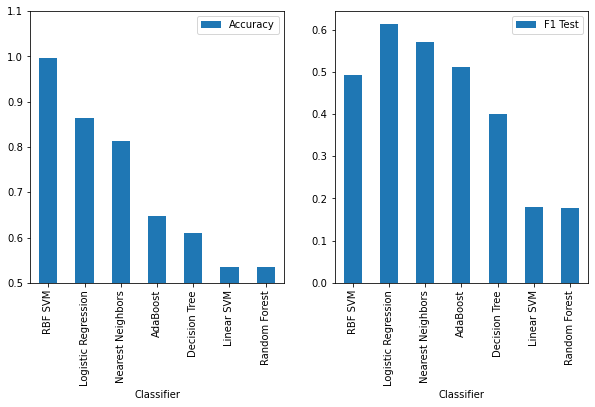

In [18]:
#visualizing the model performances for comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('Accuracy', ascending=False, inplace=True)
results.plot(y=['Accuracy'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.50,1.1])
results.plot(y='F1 Test', kind='bar', ax=ax[1])


In [ ]:
#choosing the logistic Regression
model_lg = models['Logistic Regression']
X_test =  pd.read_csv("test_with_no_labels.csv")["message"]
v_test = tfid_vectorizer.transform(X_test)
# Making predictions on the test data and adding a sentiment column 
test_data['sentiment'] = model_lg.predict(v_test)

#creating an output csv for submission
test_data[['tweetid','sentiment']].to_csv('logistic.csv', index=False)

In [ ]:
# this section must come underneath the modelling
# save model to pickle 
'''""
model_save_path = "mlr_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model, file)
'''

#### Stopping the comet experiment

In [ ]:
experiment.end()

## 7. Conclusion
[Back to Table of Contents](#Table-of-Contents)